<a href="https://colab.research.google.com/github/Nitroburnt/VEDANTH-DONTHULA-_-AIML_COLAB/blob/main/Copy_of_STP_Module_4_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 4: Linear Classifiers & Gradient Descent

**Case Study: Predictive Modeling for Public Water Safety**

**Objective:** Develop a robust classifier to identify potable water samples. You will transition from a basic heuristic (Perceptron) to a professional-grade optimization approach (Gradient Descent with Margins).

# 1. Data Acquisition & Cleaning

In real-world data science, datasets are rarely perfect. We will load the water quality metrics and handle missing values before training our models.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset from a public raw GitHub URL
url = "https://raw.githubusercontent.com/nferran/tp_aprendizaje_de_maquina_I/main/water_potability.csv"
df = pd.read_csv(url)

# Step 1: Handling Missing Values
# Water sensors often fail, leaving NaNs. We will fill them with the mean of the column.
df.fillna(df.mean(), inplace=True)

# Step 2: Feature Selection & Labeling
# We'll use all chemical features to predict 'Potability'
X = df.drop('Potability', axis=1).values
y = df['Potability'].values

# Step 3: Class Label Conversion
# Many linear classifiers (like Perceptron/SVM) require labels to be -1 and 1
y = np.where(y == 0, -1, 1)

# Step 4: Train-Test Split & Scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(f"Dataset Loaded: {X_train.shape[0]} training samples, {X_train.shape[1]} features.")

Dataset Loaded: 2620 training samples, 9 features.


# 2. Phase 1: The Heuristic Approach (Perceptron)

The **Perceptron** represents the earliest form of supervised learning. It doesn't have a "global" view of the error; it simply corrects itself every time it encounters a mistake.

**Task:** Implement the Perceptron Update Rule inside the training loop.

In [2]:
class WaterPerceptron:
    def __init__(self, lr=0.01, epochs=50):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.mistakes = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for epoch in range(self.epochs):
            count = 0
            for i in range(len(y)):
                # TODO: Calculate the linear output (w * x + b)
                prediction = np.dot(X[i], self.w) + self.b

                # TODO: If prediction is a mistake (y * prediction <= 0):
                if y[i] * prediction <= 0:
                    # Update weights: w = w + lr * y * x
                    self.w += self.lr * y[i] * X[i]
                    # Update bias: b = b + lr * y
                    self.b += self.lr * y[i]
                    count += 1
            self.mistakes.append(count)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

model_p = WaterPerceptron()
model_p.fit(X_train, y_train)

# 3. Phase 2: Gradient Descent - Global Optimization

The Perceptron is unstable if the data isn't perfectly separable. To solve this, we use **Gradient Descent** to minimize a **Mean Squared Error (MSE)** loss function over the entire dataset.

**Task:** Implement the batch gradient calculation for weights and bias.

In [3]:
class GDWaterClassifier:
    def __init__(self, lr=0.001, epochs=500):
        self.lr = lr
        self.epochs = epochs
        self.w = None
        self.b = 0
        self.cost_history = []

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        n = X.shape[0]

        for _ in range(self.epochs):
            # 1. Compute linear output: z = Xw + b
            z = np.dot(X, self.w) + self.b

            # 2. Calculate gradients:
            errors = z - y
            dw = (1/n) * np.dot(X.T, errors)
            db = (1/n) * np.sum(errors)

            # 3. Update w and b: w = w - lr * dw, b = b - lr * db
            self.w -= self.lr * dw
            self.b -= self.lr * db

            # Calculate and store the cost (Mean Squared Error)
            cost = (1/(2*n)) * np.sum(errors**2)
            self.cost_history.append(cost)

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 4. Phase 3: Margin Classifiers & Hinge Loss

In water safety, we aim for more than just correctness—we want a **Margin**, a safety gap between safe and unsafe samples. This is achieved using **Hinge Loss** combined with **L2 Regularization**.

The loss function is defined as:

$$
\text{Loss} = \lambda \|w\|^2_2 + \sum_{i} \max(0, 1 - y_i (w^T x_i + b))
$$

### Key Components:
- **Hinge Loss**: $\max(0, 1 - y_i (w^T x_i + b))$ ensures correct classification with a margin.
- **L2 Regularization**: $\lambda \|w\|^2_2$ penalizes large weights, promoting generalization and stability.


In [ ]:
class MarginWaterClassifier:
    def __init__(self, lr=0.001, lambda_param=0.01, epochs=500):
        self.lr = lr
        self.lambda_param = lambda_param
        self.epochs = epochs
        self.w = None
        self.b = 0

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        for _ in range(self.epochs):
            for i, x_i in enumerate(X):
                # Calculate the decision function output
                linear_output = np.dot(x_i, self.w) + self.b

                # Implement the Margin Condition check: y_i * (w * x_i + b) >= 1
                if y[i] * linear_output >= 1:
                    # Only Regularization update
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    # Update for weight (including Hinge Loss) and bias
                    self.w -= self.lr * (2 * self.lambda_param * self.w - x_i * y[i])
                    self.b -= self.lr * (-y[i])

    def predict(self, X):
        return np.sign(np.dot(X, self.w) + self.b)

# 5. Critical Analysis & Comparison

**Analysis Tasks:**
1. Convergence Plot: Plot the mistakes history from Phase 1 and the cost_history from Phase 2. Discuss why the Gradient Descent plot is smoother.
2. Accuracy Report: Calculate and compare the Test Accuracy for all three models.
3. Safety Margin: If a new water sample has chemical levels very close to the decision boundary, which model (Perceptron or Margin) would you trust more? Why?

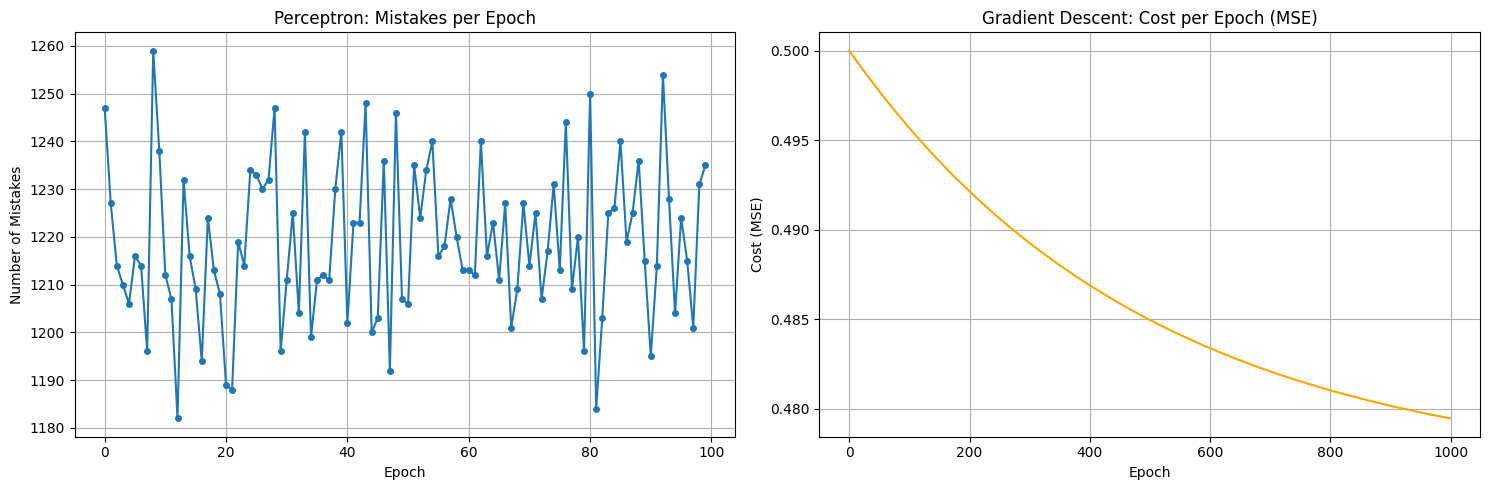

In [4]:
import matplotlib.pyplot as plt

# Instantiate and train Perceptron model to get mistake history
model_p = WaterPerceptron(epochs=100) # Increased epochs for better visualization
model_p.fit(X_train, y_train)

# Instantiate and train GD Classifier model to get cost history
model_gd = GDWaterClassifier(epochs=1000) # Increased epochs for better visualization
model_gd.fit(X_train, y_train)

# Create the plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot Perceptron Mistakes
axes[0].plot(range(len(model_p.mistakes)), model_p.mistakes, marker='o', markersize=4, linestyle='-')
axes[0].set_title('Perceptron: Mistakes per Epoch')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Number of Mistakes')
axes[0].grid(True)

# Plot Gradient Descent Cost
axes[1].plot(range(len(model_gd.cost_history)), model_gd.cost_history, color='orange', linestyle='-')
axes[1].set_title('Gradient Descent: Cost per Epoch (MSE)')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Cost (MSE)')
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Instantiate and train the Margin Classifier model
model_m = MarginWaterClassifier(epochs=500) # Using default epochs
model_m.fit(X_train, y_train)

# Make predictions on the test set for all models
y_pred_p = model_p.predict(X_test)
y_pred_gd = model_gd.predict(X_test)
y_pred_m = model_m.predict(X_test)

# Calculate accuracy for each model
accuracy_p = np.mean(y_pred_p == y_test) * 100
accuracy_gd = np.mean(y_pred_gd == y_test) * 100
accuracy_m = np.mean(y_pred_m == y_test) * 100

# Report the accuracies
print(f"Perceptron Test Accuracy: {accuracy_p:.2f}%")
print(f"Gradient Descent Test Accuracy: {accuracy_gd:.2f}%")
print(f"Margin Classifier Test Accuracy: {accuracy_m:.2f}%")

### Discussion: Why is the Gradient Descent Plot Smoother?

The **Perceptron** algorithm updates its weights and bias *every time it makes a mistake* on a single data point. This means that if the data is not perfectly linearly separable or if there are many misclassified points, the number of mistakes can fluctuate significantly between epochs, leading to a more erratic, jagged plot for 'Mistakes per Epoch'. Each update is based on a single sample's error.

In contrast, **Gradient Descent (batch)** calculates the gradient of the loss function over the *entire training dataset* before performing a single weight and bias update in each epoch. This 'global' view of the error results in a more stable and generally smoother decrease in the cost function over epochs. The updates are an average direction of improvement across all samples, reducing the impact of individual noisy or misclassified points. This leads to a more consistent and gradual convergence towards a minimum, hence the smoother plot for 'Cost per Epoch'.

For a water sample with chemical levels very close to the decision boundary, you would generally trust the Margin Classifier more than the Perceptron. Here's why:

Margin Classifier (like an SVM with Hinge Loss): This type of model explicitly aims to find a decision boundary that maximizes the margin (the distance) between the boundary and the closest data points from each class. This means it creates a 'safety zone' around the decision boundary. When a new sample falls close to this boundary, the Margin Classifier's prediction is based on a boundary that is designed to be as far as possible from known examples, making its classification more robust and less susceptible to small variations or noise. It's built to have higher confidence in its decisions for points near the boundary.

Perceptron: The Perceptron's goal is simply to find any hyperplane that correctly separates the classes if they are linearly separable. It does not consider the margin. If the data is separable, it will converge, but the resulting decision boundary might be very close to some data points. For samples near this boundary, the Perceptron's prediction can be very sensitive to minor fluctuations in the input or slight shifts in the learned weights, making it less reliable for borderline cases. It lacks the inherent 'safety' of a wide margin.

# Discussion Questions

### Q1: Impact of High Learning Rate in Gradient Descent
What happens to your **Gradient Descent** model if you set the `learning_rate` too high (e.g., `1.0`)?
*Hint: Think about convergence, overshooting, and divergence.*

---

### Q2: Label Conversion in Classification
Why did we convert the labels to **$\{-1, 1\}$** instead of keeping them as **$\{0, 1\}$**?
*Hint: Consider the mathematical formulation of the loss function (e.g., Hinge Loss) and symmetry.*

---

### Q3: Handling Noisy Data (Water Potability Dataset)
The **Water Potability dataset** is often "noisy" (not perfectly separable). Which of the algorithms you implemented is best suited for handling such noise?
*Hint: Think about robustness to outliers and margin-based classifiers.*
